# Evaluation of results
In this notebook we will evaluate the performace of our image captioning systems using BLEU as our evaluation metric and then show some examples.

Once all models were trained we used the evaluation.py script to generate a file containing all their relevant information like training parameters and BLEU-4 average scores.

In [13]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pickle
import matplotlib.pyplot as plt
import numpy as np
import yaml
import pandas as pd
from utilities import get_dataset
from pytorch_lightning.callbacks import ModelCheckpoint
from pl_model import CaptionGenerator, FlickrDataModule
import os

## Data preparation

In [14]:
#Loading evaluation file
with open('evaluation_results.pkl', 'rb') as input:
    results = pickle.load(input)

In [15]:
results[1]

{'parameters': {'batch_size': 64,
  'embed_size': 150,
  'hidden_size': 250,
  'num_layers': 1,
  'vocab_size': 3068},
 'bleu': 0.5286353581868232,
 'examples': ['<SOS> a race car is driving through a turn . <EOS>',
  '<SOS> a surfer rides a wave . <EOS>',
  '<SOS> a man in a white shirt and blue shorts is playing tennis . <EOS>',
  '<SOS> a man in a red kayak is paddling through the water . <EOS>',
  '<SOS> a man is standing on a beach with a fishing pole in the background . <EOS>']}

In [16]:
#from dict to df
parameters = {}
for k in results.keys():
    #leaving out the h_sizes parameter
    parameters[k] = {'embed_size':results[k]['parameters']['embed_size'],
                    'hidden_size':results[k]['parameters']['hidden_size'],
                    'num_layers':results[k]['parameters']['num_layers'],
                    'vocab_size':results[k]['parameters']['vocab_size'],
                     'batch_size':results[k]['parameters']['batch_size']
                    }
    results[k] = {j:v for j, v in results[k].items() if j!='parameters'}
df1 = pd.DataFrame.from_dict(results, orient= 'index')
df2 = pd.DataFrame.from_dict(parameters, orient= 'index')
df = pd.concat([df1, df2], axis=1, sort=False)

In [17]:
df.head()

,bleu,examples,embed_size,hidden_size,num_layers,vocab_size,batch_size
0,0.513966,[<SOS> a man in a red shirt and jeans is ridin...,150,250,1,3068,32
1,0.528635,[<SOS> a race car is driving through a turn . ...,150,250,1,3068,64
2,0.506664,[<SOS> a man in a red shirt is riding a bike ....,150,250,1,3068,128
3,0.546539,[<SOS> a blue race car is driving through a mu...,150,250,2,3068,32
4,0.539374,[<SOS> a race car is driving through a muddy p...,150,250,2,3068,64


## Model with the highest BLEU-4 score

In [18]:
index = df['bleu'].argmax()
print(df.iloc[index])

bleu                                                    0.546539
examples       [<SOS> a blue race car is driving through a mu...
embed_size                                                   150
hidden_size                                                  250
num_layers                                                     2
vocab_size                                                  3068
batch_size                                                    32
Name: 3, dtype: object


## Plotting results to identify the best performing parameters

### Comparing between embedding sizes

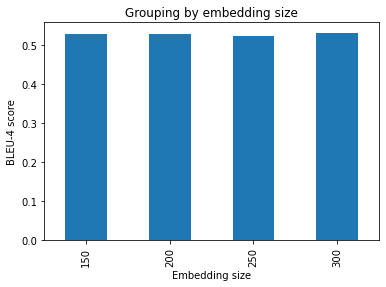

In [19]:
df.groupby('embed_size')['bleu'].mean().plot(kind = 'bar', title = 'Grouping by embedding size')
plt.ylabel('BLEU-4 score')
plt.xlabel('Embedding size')
plt.show()

In [20]:
df.groupby('embed_size')['bleu'].mean()

embed_size
150    0.528187
200    0.528157
250    0.524695
300    0.532504
Name: bleu, dtype: float64

### Comparing between number of LSTM layers

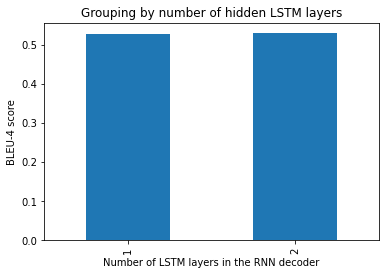

In [21]:
df.groupby('num_layers')['bleu'].mean().plot(kind = 'bar', title = 'Grouping by number of hidden LSTM layers')
plt.ylabel('BLEU-4 score')
plt.xlabel('Number of LSTM layers in the RNN decoder')
plt.show()

In [22]:
df.groupby('num_layers')['bleu'].mean()

num_layers
1    0.526821
2    0.529477
Name: bleu, dtype: float64

### Comparing between batch_sizes

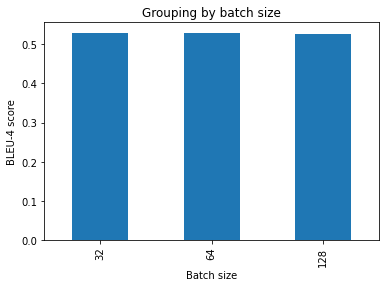

In [23]:
df.groupby('batch_size')['bleu'].mean().plot(kind = 'bar', title = 'Grouping by batch size')
plt.ylabel('BLEU-4 score')
plt.xlabel('Batch size')
plt.show()

In [24]:
df.groupby('batch_size')['bleu'].mean()

batch_size
32     0.530308
64     0.528770
128    0.525612
Name: bleu, dtype: float64

### Conclusion
None of the above parameters seem to have a big impact on the BLEU-4 score.

## (Our) Possible human evaluation?
Here we can see our models' performance on a fixes set of 5 images extracted from the test set. It is hard to select a best performing model based on so few examples, but this approach could be scaled up using Amazon Mechanical Turk or another human evaluation platform, in order to break the dependance on automated metrics. 

In [13]:
correct = ['A man drives an old-fashioned red race car.', 'Man paddling in blue kayak in the water.', 'The tennis player in the blue shirt is holding his racquet up in the air.', 'A man wearing a wetsuit is climbing a rock along a beach.', 'A pelican flies over the water.']

CORRECT:  A man drives an old-fashioned red race car.

<SOS> a man in a red shirt and jeans is riding a bike on a dirt track . <EOS>
<SOS> a race car is driving through a turn . <EOS>
<SOS> a man in a red shirt is riding a bike . <EOS>
<SOS> a blue race car is driving through a muddy puddle . <EOS>
<SOS> a race car is driving through a muddy puddle . <EOS>
<SOS> a race car is driving through the air . <EOS>
<SOS> a race car is driving through a mud puddle . <EOS>
<SOS> a race car driver is driving through the mud . <EOS>
<SOS> a race car is driving through the air . <EOS>
<SOS> a race car is driving through a muddy puddle . <EOS>
<SOS> a race car is driving through a muddy track . <EOS>
<SOS> a man is riding a motorcycle on a track . <EOS>
<SOS> a race car drives on a track . <EOS>
<SOS> a race car is driving through a muddy puddle . <EOS>
<SOS> a race car is driving through a muddy puddle . <EOS>
<SOS> a race car is driving through a muddy track . <EOS>
<SOS> a race car is driving thr

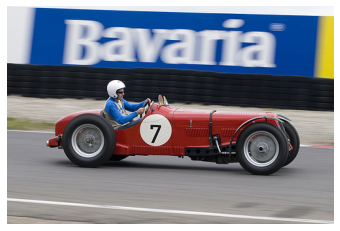

In [14]:
plt.axis('off')
plt.imshow(Image.open('../../data/caption_generator/test_examples/race_car.jpg'))
print('CORRECT: ', correct[0])
print()
for ex in df['examples']:
    print(ex[0])
print('============================')

CORRECT:  Man paddling in blue kayak in the water.

<SOS> a man in a blue shirt is surfing on a wave . <EOS>
<SOS> a surfer rides a wave . <EOS>
<SOS> a man in a blue shirt is surfing a wave . <EOS>
<SOS> a man in a wetsuit is surfing . <EOS>
<SOS> a man in a wetsuit is surfing on a wave . <EOS>
<SOS> a man in a wetsuit is surfing on a surfboard . <EOS>
<SOS> a man is surfing on a wave . <EOS>
<SOS> a man in a wetsuit surfing a wave . <EOS>
<SOS> a man in a wetsuit is surfing a wave . <EOS>
<SOS> a man in a wetsuit surfing a wave . <EOS>
<SOS> a man in a wetsuit surfing . <EOS>
<SOS> a surfer is jumping over a wave . <EOS>
<SOS> a man in a wetsuit surfing a wave . <EOS>
<SOS> a man in a blue wetsuit is surfing on a wave . <EOS>
<SOS> a man in a wetsuit surfing a wave . <EOS>
<SOS> a man in a wetsuit is surfing a wave . <EOS>
<SOS> a man in a wetsuit is surfing . <EOS>
<SOS> a man is surfing on a surfboard . <EOS>
<SOS> a man in a yellow kayak is paddling through rapids . <EOS>
<SOS> a 

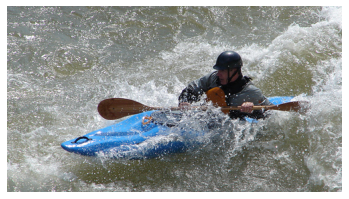

In [15]:
plt.axis('off')
plt.imshow(Image.open('../../data/caption_generator/test_examples/kayak.jpg'))
print('CORRECT: ', correct[1])
print()
for ex in df['examples']:
    print(ex[1])
print('============================')

CORRECT:  The tennis player in the blue shirt is holding his racquet up in the air.

<SOS> a man in a white shirt is playing tennis . <EOS>
<SOS> a man in a white shirt and blue shorts is playing tennis . <EOS>
<SOS> a man in a red shirt is playing with a tennis ball . <EOS>
<SOS> a tennis player in a red shirt is running with a ball . <EOS>
<SOS> a man in a red shirt is playing tennis . <EOS>
<SOS> a boy in a blue shirt is playing with a soccer ball . <EOS>
<SOS> a man in a white shirt and a baseball cap is playing tennis . <EOS>
<SOS> a man in a blue shirt and blue shorts is playing tennis . <EOS>
<SOS> a boy in a red shirt is playing with a soccer ball . <EOS>
<SOS> a man in a white shirt and blue shorts is playing tennis . <EOS>
<SOS> a man in a blue shirt and blue shorts is playing tennis . <EOS>
<SOS> a man in a red shirt is playing a game . <EOS>
<SOS> a man in a blue shirt is playing tennis . <EOS>
<SOS> a tennis player in a red uniform is running . <EOS>
<SOS> a man in a red s

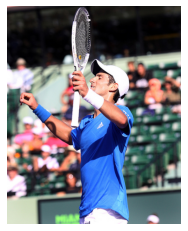

In [16]:
plt.axis('off')
plt.imshow(Image.open('../../data/caption_generator/test_examples/tennis.jpg'))
print('CORRECT: ', correct[2])
print()
for ex in df['examples']:
    print(ex[2])
print('============================')

CORRECT:  A man wearing a wetsuit is climbing a rock along a beach.

<SOS> a man in a blue shirt is climbing a rock . <EOS>
<SOS> a man in a red kayak is paddling through the water . <EOS>
<SOS> a man in a blue shirt is standing on a rock overlooking a lake . <EOS>
<SOS> a man is standing on a rock overlooking a waterfall . <EOS>
<SOS> a man is standing on a cliff overlooking the ocean . <EOS>
<SOS> a man in a red jacket is standing on a rock in the ocean . <EOS>
<SOS> a man is standing on a rock overlooking a valley . <EOS>
<SOS> a man in a red shirt is climbing a rock wall . <EOS>
<SOS> a man is standing on a cliff overlooking a lake . <EOS>
<SOS> a man is standing on a cliff overlooking the ocean . <EOS>
<SOS> a man is standing on a rock overlooking a river . <EOS>
<SOS> a man is standing on a rock overlooking a lake . <EOS>
<SOS> a man is standing on top of a mountain gazing at the ocean . <EOS>
<SOS> a man is standing on a cliff overlooking the ocean . <EOS>
<SOS> a man in a red s

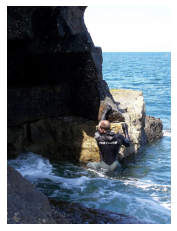

In [17]:
plt.axis('off')
plt.imshow(Image.open('../../data/caption_generator/test_examples/scuba.jpg'))
print('CORRECT: ', correct[3])
print()
for ex in df['examples']:
    print(ex[3])
print('============================')

CORRECT:  A pelican flies over the water.

<SOS> a man is surfing on a wave . <EOS>
<SOS> a man is standing on a beach with a fishing pole in the background . <EOS>
<SOS> a man in a blue shirt is standing on a rock overlooking a lake . <EOS>
<SOS> a man is standing on a cliff overlooking the ocean . <EOS>
<SOS> a man is surfing on a surfboard . <EOS>
<SOS> a man in a wetsuit is surfing on a surfboard . <EOS>
<SOS> a dog swims in the water . <EOS>
<SOS> a surfer is falling off a wave . <EOS>
<SOS> a man is surfing a wave . <EOS>
<SOS> a dog is swimming in a lake . <EOS>
<SOS> a dog swims in the water . <EOS>
<SOS> a man is surfing on a wave . <EOS>
<SOS> a man is kayaking in the ocean . <EOS>
<SOS> a man is surfing in the ocean . <EOS>
<SOS> a man in a wetsuit surfing a wave . <EOS>
<SOS> a dog swims in the water . <EOS>
<SOS> a man is surfing on a large wave . <EOS>
<SOS> a dog is jumping into the water . <EOS>
<SOS> a man in a black wetsuit is surfing in the ocean . <EOS>
<SOS> a man 

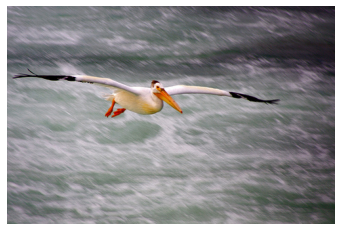

In [18]:
plt.axis('off')
plt.imshow(Image.open('../../data/caption_generator/test_examples/bird.jpg'))
print('CORRECT: ', correct[4])
print()
for ex in df['examples']:
    print(ex[4])
print('============================')